In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
%matplotlib inline
import random
from sklearn import preprocessing
import scipy.sparse as sparse
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import cross_validation as cv

## Overview

This Notebook implements Matrix Factorization without a specific library for such

- Matrix Factorization alone produced a Test RMSE of .80
- Simple Averaging produced a Test RMSE of .75
- Combining Matrix Factorization and Simple Averaging Reduced test RMSE  of .74


In [4]:
df = pd.read_csv('datasets/frequent_reviews.txt')
df.head()

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A9GPEIJ6JS3UE,B000JMLBHU,Amazon Customer,"[0, 0]",1350432000,"This classic is a must read, especial for anyo...",4.0,"10 17, 2012",Jules Verne is arguably one of the great writters
1,ABDR6IJ93HFIO,B000JMLBHU,"Daisy ""Daisy S""","[0, 0]",1394409600,"Read this book years ago and enjoyed it then, ...",5.0,"03 10, 2014","A story of determination, a group finding answ..."
2,AU58Q4M7NCYC9,B000JMLBHU,"David G ""science fiction and fantasy fanatic""","[0, 0]",1404000000,"Every child should read 20,000 leagues under t...",4.0,"06 29, 2014",a classic every child should read - sequel to ...
3,A32A056Q9OYP7D,B000JMLBHU,Ricky KImsey,"[0, 0]",1388016000,A group of men escape by balloon a Confederate...,5.0,"12 26, 2013",Island Mystery
4,A71W7G4TCTH3T,B002AJ7X2C,"BBMoreB ""Heather Coulter""","[1, 2]",1245110400,This short story about 2 serial killers is bot...,4.0,"06 16, 2009",3 Distrubing Chapters - Wish it was longer!


## Clean Data

In [5]:
df = df.drop(['helpful','reviewText','reviewTime','reviewerName','summary','unixReviewTime'],1)
df.head()

,reviewerID,asin,overall
0,A9GPEIJ6JS3UE,B000JMLBHU,4.0
1,ABDR6IJ93HFIO,B000JMLBHU,5.0
2,AU58Q4M7NCYC9,B000JMLBHU,4.0
3,A32A056Q9OYP7D,B000JMLBHU,5.0
4,A71W7G4TCTH3T,B002AJ7X2C,4.0


In [6]:
#Encode categorical variables
def encode_categorical(array):
    if array.dtype != np.dtype('float'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array

In [7]:
# Categorical columns for use in one-hot encoder
categorical = (df.dtypes.values != np.dtype('float'))

In [8]:
categorical

array([ True,  True, False], dtype=bool)

In [9]:
# Encode all labels
df = df.apply(encode_categorical)

In [10]:
df.head()

,reviewerID,asin,overall
0,681,0,4.0
1,696,0,5.0
2,784,0,4.0
3,445,0,5.0
4,660,1,4.0


In [11]:
df.columns = ['user_id', 'item_id', 'rating']

In [12]:
df.head()

,user_id,item_id,rating
0,681,0,4.0
1,696,0,5.0
2,784,0,4.0
3,445,0,5.0
4,660,1,4.0


In [13]:
df.to_csv('datasets/frequent_reviewsInt.csv', index = False)

# Matrix Factorization - Prepare Matrixes

In [14]:
# Calculate the RMSE with Latent Features Matrices 
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - prediction(P,Q)))**2)/len(R[R > 0]))

In [15]:
# Calculate the RMSE with full User Item matrix of Predictions
def rmseMTX(I, R_True,R_Hat):
    return np.sqrt(np.sum((I * (R_True - R_Hat))**2)/len(R_True[R_True > 0]))

In [16]:
maxScore = 5
minScore = 1
# Predict the unknown ratings through the dot product of the latent features for users and items 
# Limit Predictions to be only so high and so low
def prediction(P,Q):
    #return np.dot(P.T,Q)
    return np.maximum(np.minimum(np.dot(P.T,Q),maxScore),minScore)

In [17]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

In [18]:
train_data, test_data = cv.train_test_split(df,test_size=0.30)
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [19]:
# Create training and test matrix
R = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    R[line[1]-1, line[2]-1] = line[3] 
    
T = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    T[line[1]-1, line[2]-1] = line[3]

In [20]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

## Prepare Baseline Model - Produce their User Item Predict Matrices

In [21]:
# Always Predict the constant value always
# Return User Item Matrix of Predictions
def alwaysMTX(always):
    return np.ones((n_users, n_items))*always

In [22]:
### Simple Avg Matrix - Train Total Average
avgR = np.sum(R)/np.sum(R!=0)
R_PopAvg = alwaysMTX(avgR)

In [23]:
#Given wItem 
def simpAvgMtx(wItem):
    ### Simple Avg Matrix - Weighted Item Avg, Weighted User Avg
    R_SimpAvg = R.copy()

    wUser = 1-wItem

    for i in range(n_users):
        for j in range(n_items):
            n_user = np.sum(R[i,:] != 0)
            n_item = np.sum(R[:,j] != 0)
            itemAvg = None
            userAvg = None
            predict = None
            if n_user == 0 and n_item == 0:
                predict = avgR
            elif n_user == 0:
                itemAvg =  np.sum(R[:,j])/n_item
                predict = itemAvg
            elif n_item == 0:
                userAvg =  np.sum(R[i,:])/n_user
                predict = userAvg
            else:
                itemAvg =  np.sum(R[:,j])/n_item
                userAvg =  np.sum(R[i,:])/n_user
                predict = wItem*itemAvg + wUser * userAvg
            R_SimpAvg[i,j] = predict
    return R_SimpAvg

In [31]:
constants = [3,3.25,3.5,3.75,4,4.25,avgR,4.5,4.75,5]
RMSE_List_Always = []

for constant in constants:
    alwaysPredictions = alwaysMTX(constant)
    RMSE_List_Always.append(rmseMTX(I2,T,alwaysPredictions))

In [32]:
RMSE_List_Always

[1.5817229767117049,
 1.3805080732888542,
 1.1978136356602691,
 1.0434138541976716,
 0.93148668079023411,
 0.878420401543347,
 0.87585634996158923,
 0.8947498908664604,
 0.97700170550696097,
 1.1106247331666435]

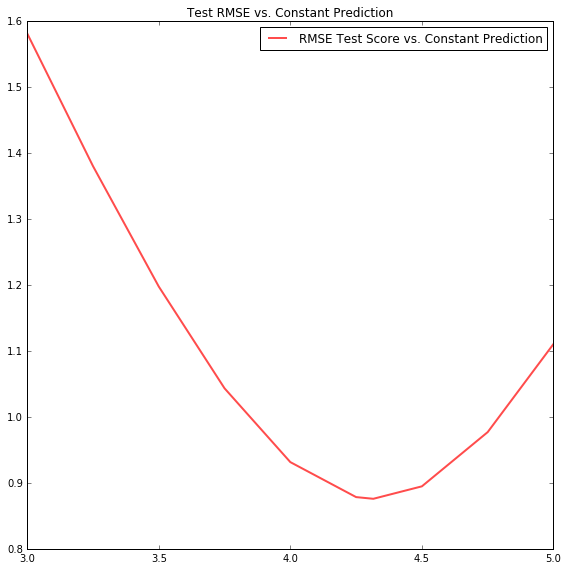

In [33]:

#plot R^2 Values
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 8))


# plot R^2 Test
ax1.plot(constants, 
            RMSE_List_Always, 
            color='red',
            linewidth=2.0,
            alpha=0.7,
            label="RMSE Test Score vs. Constant Prediction")
    
ax1.legend(loc='best')
ax1.set_title('Test RMSE vs. Constant Prediction')

plt.tight_layout()
plt.show()

In [92]:
weights = np.array(range(0,11))*.1

In [93]:
RMSE_List = []

for weight in weights:
    simpleAvgPredictions = simpAvgMtx(weight)
    RMSE_List.append(rmseMTX(I2,T,simpleAvgPredictions))

In [94]:
RMSE_List

[0.76663577769851565,
 0.75657991285385617,
 0.75164158575353801,
 0.75192163311600624,
 0.75741426661714994,
 0.76800765635256063,
 0.78349493244737367,
 0.80359319194408352,
 0.82796671860688353,
 0.85625049846176715,
 0.88807100229936764]

In [100]:
print "Min Simple Average: %0.3f" %min(RMSE_List)
print "Optimal Item weight: %0.1f" %weights[np.argmin(RMSE_List)]

Min Simple Average: 0.752
Optimal Item weight: 0.2


In [ ]:
optItemWeight = weights[np.argmin(RMSE_List)]

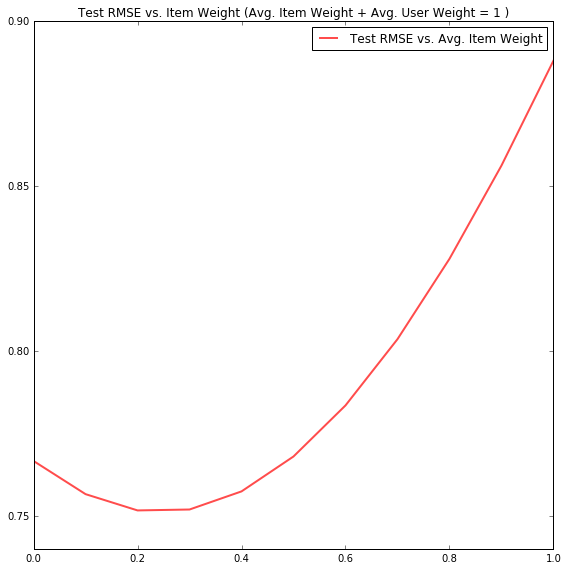

In [95]:

#plot R^2 Values
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 8))


# plot R^2 Test
ax1.plot(weights, 
            RMSE_List, 
            color='red',
            linewidth=2.0,
            alpha=0.7,
            label="Test RMSE vs. Avg. Item Weight")
    
ax1.legend(loc='best')
ax1.set_title('Test RMSE vs. Item Weight (Avg. Item Weight + Avg. User Weight = 1 )')

plt.tight_layout()
plt.show()

## Apply Matrix Factorization

In [22]:
lmbda = .25 # Regularisation weight
k = 8  # Dimension of the latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 100  # Number of epochs
gamma=0.01  # Learning rate

In [23]:
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [24]:
train_errors = []
test_errors = []

In [25]:
#Only consider non-zero matrix 
users,items = R.nonzero()      
for epoch in xrange(n_epochs):
    for u, i in zip(users,items):
        e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
        P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    train_rmse = rmse(I,R,Q,P) # Calculate root mean squared error from train dataset
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

#### Stochastic Gradient Descent ####


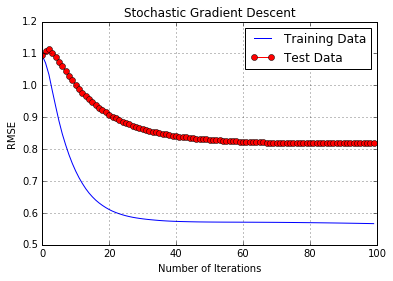

In [29]:
# Check performance by - Weighted Lambda Regression plotting train and test errors
print "#### Stochastic Gradient Descent ####"
plt.plot(range(n_epochs), train_errors, label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='o', color = 'red', label='Test Data');
plt.title('Stochastic Gradient Descent')
plt.xlabel('Number of Iterations');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [107]:
print "Matrix Factorization Test RMSE:     %0.4f" %test_rmse

Matrix Factorization Test RMSE:     0.8029


** Review Actual Predictions from Matrix Factorization **

In [108]:
R_MF = prediction(P,Q)

In [109]:
R_MF

array([[ 3.20082586,  4.29361477,  4.24827483, ...,  4.93395675,
         4.74449529,  4.2387998 ],
       [ 3.63519855,  5.        ,  5.        , ...,  5.        ,
         5.        ,  5.        ],
       [ 3.54335274,  4.73171342,  4.60976241, ...,  5.        ,
         5.        ,  4.32512869],
       ..., 
       [ 3.06253129,  4.2020303 ,  3.97548191, ...,  4.57856252,
         4.46362656,  3.56003436],
       [ 3.27716648,  3.86861349,  3.6484738 , ...,  4.17547335,
         4.11464736,  3.42838326],
       [ 3.03074167,  4.13310091,  4.16876115, ...,  4.77730448,
         4.63355568,  3.97258075]])

## Grid Search For Optimal Parameters

In [33]:
def mfTestRMSE(lmda, k):
    P = 3 * np.random.rand(k,m) # Latent user feature matrix
    Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
    #Only consider non-zero matrix 
    users,items = R.nonzero()      
    for epoch in xrange(n_epochs):
        for u, i in zip(users,items):
            e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
            P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
            Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    test_rmse = rmse(I2,T,Q,P) # Calculate root mean squared error from test dataset
    return test_rmse

In [34]:
def mfPredictions(lmda, k):
    P = 3 * np.random.rand(k,m) # Latent user feature matrix
    Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
    #Only consider non-zero matrix 
    users,items = R.nonzero()      
    for epoch in xrange(n_epochs):
        for u, i in zip(users,items):
            e = R[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient
            P[:,u] += gamma * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
            Q[:,i] += gamma * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent movie feature matrix
    return prediction(P,Q)

In [52]:
## Grid Search for Optimal Parameters
lmbdaList = [.01,.25,.50,.75,1,10] # Regularisation weight
kList = [5,10,20,40]  # Dimension of the latent feature space
paramTupList =[]
testScoreList =[]


for currL in lmbdaList:
    for currK in kList:
        paramTupList.append((currL,currK))
        testScoreList.append(mfTestRMSE(currL,currK))
        

In [53]:
### Lowest Test Score
print "Lowest Test RMSE:     %0.4f" %min(testScoreList)

Lowest Test Accuracy:     0.7944


In [54]:
print "Optimal Lambda and K Features:     %s" %(paramTupList[np.argmin(testScoreList)],)

Optimal Lambda and K Features:     (0.5, 5)


In [125]:
optimalParam = paramTupList[np.argmin(testScoreList)]

## Combining Matrix Factorization and Simple Averaging

In [31]:
weights = np.array(range(0,11))*.1

In [35]:
R_MF = mfPredictions(optimalParam[0],optimalParam[1])

In [37]:
R_SimpAvg = simpAvgMtx(optItemWeight)

In [115]:
RMSE_List = []

for weight in weights:
    RMSE_List.append(rmseMTX(I2,T,weight*R_SimpAvg +(1-weight)*R_MF))

In [116]:
RMSE_List

[0.80114925144230709,
 0.78741214777206492,
 0.77545903078311373,
 0.76537348855234077,
 0.75723014739648142,
 0.75109218200234107,
 0.74700902685014581,
 0.74501446772380842,
 0.74512527713908661,
 0.74734051859713524,
 0.75164158575353801]

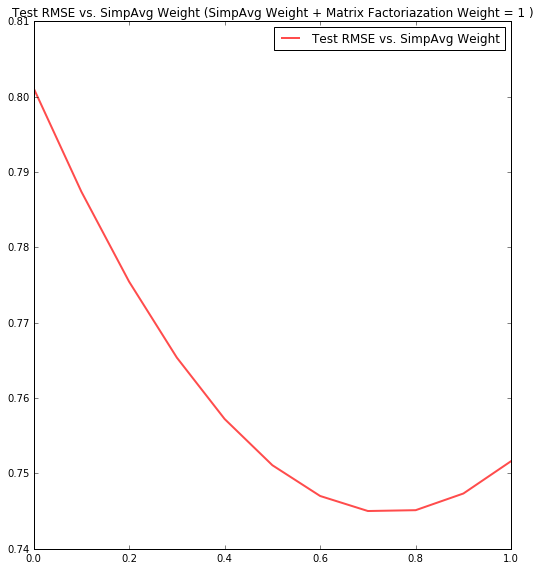

In [39]:

#plot R^2 Values
fig, ((ax1)) = plt.subplots(1, 1, figsize=(8, 8))


# plot R^2 Test
ax1.plot(weights, 
            RMSE_List, 
            color='red',
            linewidth=2.0,
            alpha=0.7,
            label="Test RMSE vs. SimpAvg Weight")
    
ax1.legend(loc='best')
ax1.set_title('Test RMSE vs. SimpAvg Weight (SimpAvg Weight + Matrix Factoriazation Weight = 1 )')

plt.tight_layout()
plt.show()

In [118]:
print "Min Ensemble RMSE: %0.3f" %min(RMSE_List)
print "Optimal SimpAvg weight: %0.1f" %weights[np.argmin(RMSE_List)]

Min Ensemble RMSE: 0.745
Optimal SimpAvg weight: 0.7


## Reviewing what Matrix Factorization is actually predicting

In [119]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
R_DF = pd.DataFrame(R)
R_hat=pd.DataFrame(prediction(P,Q))

In [120]:
# Compare true ratings of user N with predictions for Train
userN = 16

ratings = pd.DataFrame(data=R_DF.loc[userN,R_DF.loc[userN,:] > 0]).head(n=10)
ratings['Prediction'] = R_hat.loc[userN,R_DF.loc[userN,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
328,5.0,4.779014
458,5.0,4.832624
579,5.0,4.799448
650,5.0,4.779587
669,5.0,4.816993
729,5.0,4.627396
793,5.0,4.259399
807,5.0,4.761451
832,5.0,4.843581


In [121]:
# Calculate prediction matrix R_hat (low-rank approximation for R)
T_DF = pd.DataFrame(T)
T_hat=pd.DataFrame(prediction(P,Q))

In [122]:
# Compare true ratings of user N with predictions for Test
userN = 16

ratings = pd.DataFrame(data=T_DF.loc[userN,T_DF.loc[userN,:] > 0]).head(n=10)
ratings['Prediction'] = T_hat.loc[userN,T_DF.loc[userN,:] > 0]
ratings.columns = ['Actual Rating', 'Predicted Rating']
ratings

,Actual Rating,Predicted Rating
672,5.0,4.798832
876,5.0,3.963290


This notebook references the below tutorial:

http://online.cambridgecoding.com/notebooks/mhaller/implementing-your-own-recommender-systems-in-python-using-stochastic-gradient-descent-4